## Basics

### Imports

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

In [2]:
import torch

os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
print(torch.__version__)
print(torch.cuda.is_available())  # True if CUDA is installed
print(torch.cuda.get_device_name(0))  # Should show NVIDIA GeForce RTX 4080

2.5.1
True
NVIDIA GeForce RTX 4080


### Working Directory Path

In [3]:
# Google Drive Path for Running on Colab
# from google.colab import drive
# drive.mount('/content/drive')
# path = "drive/MyDrive/MSc Thesis/"

In [4]:
# Local Path for Running Locally
path = "../data/"
path_images = path + "images/"
path_export = path + "features/"
os.makedirs(path_export, exist_ok=True)

### Read Pre-Processed Data

In [5]:
data = pd.read_csv(path + 'agora12_data_pp.csv')
data

,Id,FullText,ImageFilename,StartYear,EndYear,MidpointYear,YearRange,HistoricalPeriod,ValidChronology
0,Agora:Object:Agora XII:1,foot missing. offset neck and echinoid mouth; ...,Agora_Image_2012.54.1450.jpg,-575.0,-550.0,-562.5,25.0,Archaic,True
1,Agora:Object:Agora XII:2,spreading ring foot with torus outer and conve...,NaN,-525.0,-500.0,-512.5,25.0,Archaic,True
2,Agora:Object:Agora XII:3,flaring ring foot. torus mouth. ridge at junct...,NaN,-500.0,-500.0,-500.0,0.0,Archaic,True
3,Agora:Object:Agora XII:4,ring foot. echinoid mouth inset from neck and ...,NaN,-500.0,-500.0,-500.0,0.0,Archaic,True
4,Agora:Object:Agora XII:5,echinus ring foot. torus mouth; strap handles....,Agora_Image_2012.27.0009.jpg,-525.0,-500.0,-512.5,25.0,Archaic,True
...,...,...,...,...,...,...,...,...,...
1995,Agora:Object:Agora XII:2036,fragment of rim and floor with handle. deep ba...,NaN,-350.0,-320.0,-335.0,30.0,Classical,True
1996,Agora:Object:Agora XII:2037,handles missing. basin and lid; handles probab...,Agora_Image_2012.55.1261.jpg,-350.0,-301.0,-325.5,49.0,Classical,True
1997,Agora:Object:Agora XII:2038,small series. plain flat-topped rim; flaring b...,Agora_Image_2012.25.0184.jpg,-435.0,-425.0,-430.0,10.0,Classical,True
1998,Agora:Object:Agora XII:2039,"small series. rim flat on top, roughly moulded...",Agora_Image_2012.55.1268.jpg,-375.0,-325.0,-350.0,50.0,Classical,True


In [6]:
data = data.astype({'ImageFilename': 'string'})

## Helper Functions

### Missing Image Check

In [7]:
def missing_image(image_filename):
    return not isinstance(image_filename, str)

### Put Vectors in DataFrame

In [8]:
def to_df(vectors, offset=0):
    return pd.DataFrame(
        vectors,
        columns=[f"F{i}" for i in range(offset, vectors.shape[1] + offset)]
    )

### Tensors to Vectors Conversion

In [9]:
def tensors_to_vectors(tensor_list):
    vectors = [tensor.cpu().numpy() for tensor in tensor_list]
    vectors = np.vstack(vectors)
    vectors = to_df(vectors)
    return vectors

### Export Tensors to .pt File

In [10]:
def export_tensors(tensors, data_type, method):
    file_path = path_export + data_type + "_" + method + "_tensors.pt"
    torch.save(
        tensors,
        file_path
    )
    # to import: tensors = torch.load(file_path)

### Export Vectors to .csv File

In [11]:
def export_vectors(vectors, data_type, method):
    file_path = path_export + data_type + "_" + method + "_vectors.csv"
    vectors.to_csv(
        file_path,
        index=False,
        encoding='utf-8',
        sep=',',
        header=True
    )

## Feature Extraction from Text Data

### TF-IDF

✔ **Best for:** Traditional ML models (Random Forest, XGBoost, SVM).

✔ **Why use it?**
- Captures word importance across the dataset.
- Works well with structured text like archaeological descriptions.
- Computationally efficient, doesn’t require a large dataset.

🔹 **Pros:** Fast, interpretable, low resource usage.

🔹 **Cons:** Doesn’t capture word relationships (e.g., "small bowl" and "bowl small" are treated differently).

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=300,  # Use top 300 important words // TODO FINE TUNE
    stop_words='english'
)

In [13]:
# Vectorize the text using TF-IDF
tfidf_vectors = vectorizer.fit_transform(data["FullText"]).toarray()
tfidf_vectors.shape

(2000, 300)

In [14]:
# Convert to DataFrame
tfidf_vectors = to_df(tfidf_vectors)
tfidf_vectors

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F290,F291,F292,F293,F294,F295,F296,F297,F298,F299
0,0.000000,0.0,0.0,0.111096,0.0,0.0,0.0,0.135608,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.138878,0.0,0.000000,0.0
1,0.198975,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.227714,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
1996,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.166597,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
1997,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.150761,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.222329,0.0
1998,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.195686,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


In [15]:
export_vectors(tfidf_vectors, 'text', 'tfidf')

### BERT

 Pretrained BERT models convert text (pottery descriptions, classifications, and dimensions) into dense numerical embeddings.

✅ Pros:
- Fast with low compute cost.
- Good for small datasets.
- Understands context better than TF-IDF
- Combines perfectly with images, dimensions, deposits for mixed models.

❌ Cons:
- Doesn’t adapt BERT to archaeology-specific vocabulary.

In [16]:
from transformers import AutoTokenizer, AutoModel

**Load BERT**
- "bert-base-uncased" is the standard English BERT — lowercased, pretrained on Wikipedia and BooksCorpus.
- Tokenizer will convert your text into token IDs and attention masks.
- Model will turn those token IDs into a vector representation (embedding).

In [17]:
# Load the tokenizer and BERT model
model_name = "bert-base-uncased"  # "sentence-transformers/all-MiniLM-L6-v2" for optimized embeddings
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

**Text to BERT Embedding Function**
- The function takes raw text and returns a 768-dimensional vector (BERT’s hidden size).
- `tokenizer` converts text to token IDs and attention masks.
- `inputs = {key: val.to("cuda")}` moves all input tensors to GPU.
- ``model.to("cuda")`` ensures the model uses the GPU too.
- ``with torch.no_grad()`` tells PyTorch: no gradients needed (inference mode, not training).
- ``outputs.last_hidden_state[:, 0, :]``: grabs the first token’s embedding ([CLS]) which BERT uses to summarize the whole sequence.

In [18]:
def get_bert_embedding_tensor(text):
    if pd.isna(text) or text.strip() == "":
        return torch.zeros(768).to("cuda")  # Fallback for empty text

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    # Move each tensor in the dict to CUDA
    inputs = {key: val.to("cuda") for key, val in inputs.items()}
    model.to("cuda")  # Make sure the model is on CUDA too!

    with torch.no_grad():
        outputs = model(**inputs)

    bert_embedding_tensor = outputs.last_hidden_state[:, 0, :].squeeze()
    return bert_embedding_tensor

**BERT Embedding Tensors**

Apply text to BERT embedding tensor transformation to all records

In [19]:
bert_embedding_tensor_list = data["FullText"].apply(get_bert_embedding_tensor).tolist()

Stack tensors into single tensor for neural network pipelines

In [20]:
bert_embedding_tensors = torch.stack(bert_embedding_tensor_list)
bert_embedding_tensors.shape

torch.Size([2000, 768])

In [21]:
export_tensors(bert_embedding_tensors, 'text', 'bert')

**BERT Embedding Vectors**

Convert tensors to 2D NumPy Matrix for classic ML methods

In [22]:
bert_embedding_vectors = tensors_to_vectors(bert_embedding_tensor_list)
bert_embedding_vectors.shape

(2000, 768)

In [23]:
bert_embedding_vectors.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F758,F759,F760,F761,F762,F763,F764,F765,F766,F767
0,-0.898724,-0.486162,0.028219,-0.459437,0.025975,0.171785,-0.225704,0.598198,-0.671418,-0.360748,...,0.544853,-0.094505,0.119364,-0.406123,-0.156514,0.057351,-0.590477,0.082195,0.056427,0.636600
1,-0.885465,-0.397205,0.022870,-0.205537,0.181872,0.607549,0.165552,0.365950,-0.376914,-0.537811,...,0.688338,-0.050159,0.473367,-0.819681,-0.078600,-0.009349,-0.557259,-0.031592,-0.239693,0.434030
2,-0.963523,-0.258176,-0.118784,-0.288602,-0.392911,0.519720,0.058223,0.555198,-0.410730,-0.450699,...,0.375797,-0.043968,0.511510,-0.226731,-0.199920,-0.223036,-0.620085,0.285992,-0.009058,0.618584
3,-1.070314,-0.210987,-0.103423,-0.202009,-0.187466,0.723891,0.115893,0.936028,-0.535789,-0.510405,...,0.489037,0.197952,0.435690,-0.198381,-0.329297,-0.415185,-0.845875,-0.247388,0.447077,0.470026
4,-1.090099,-0.287609,-0.185384,-0.211187,0.005837,0.468886,-0.136760,0.768961,-0.004133,-0.257237,...,0.457164,0.138810,0.479057,0.022566,-0.330094,-0.500518,-0.597981,0.021964,0.029257,0.401163


In [24]:
export_vectors(bert_embedding_vectors, 'text', 'bert')

### Fine-Tuning BERT

✅ Pros:
- BERT learns from the specific archaeology vocabulary of the data.
- Usually higher performance for text-heavy tasks.

❌ Cons:
- Takes longer to train.
- Harder to combine with images.

In [25]:
#### TO DO: TRY FINE TUNING ######

## Feature Extraction from Images

### Pretrained CNNs (Transfer Learning)

Pretrained Convolutional Neural Networks (CNNs) trained on ImageNet (millions of images) to extract feature vectors.

✅ Pros:
- Good for small dataset, no training needed.
- Despite being trained on everyday objects, they can recognize visual patterns of pottery like:
  - shape contours,
  - textures,
  - edges and symmetries

❌ Cons:
- Not specialized to archaeological images.


#### ResNet

PIL (Pillow) Library:
- Python-native image manipulation: loading, resizing, cropping, saving images
- Loads images as RGB
- Very compatible with torchvision and Hugging Face's workflows

In [26]:
from torchvision import transforms
from torchvision.models import resnet50
from PIL import Image

**Preprocessing Steps for Input Images**

- ``transforms.Resize((224, 224))``: Resize to 224x224 pixels (size of images ResNet is trained on)
- ``transforms.ToTensor()``: Convert to a PyTorch tensor with pixel values scaled to [0, 1]
- ``transforms.Normalize()``: Standardize pixel values using the ImageNet mean and std — the same normalization the original ResNet model expects

In [27]:
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Load & Adjust Pretrained ResNet Model**

- Load ResNet50 architecture from PyTorch, with default weights trained on ImageNet.
- Remove the classification layer (last linear layer), to only use ResNet for feature extraction and not classification.
- Set to evaluation/interface mode (no dropout, no batch norm updates) and move to GPU

In [28]:
resnet = resnet50(weights='DEFAULT')
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.eval().cuda()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


**Feature Extraction Process**

- Open image and ensure it has 3 channels (RGB)
- Apply the preprocessing steps to the image
- Add batch dimension, new shape: [1, 3, 224, 224], as ResNet expects its input
- Move tensor to GPU
- Turn off gradient tracking (faster, uses less memory)
- Pass the image through the model to get the feature vector

In [29]:
def extract_resnet_features(image_filename):
    if missing_image(image_filename):
        return torch.zeros(2048).to("cuda")  # if missing image return zero tensor

    image = Image.open(path_images + image_filename).convert("RGB")
    image_tensor = resnet_transform(image).unsqueeze(0).cuda()
    with torch.no_grad():
        features = resnet(image_tensor).squeeze()
    return features

In [30]:
resnet_image_tensor_list = data["ImageFilename"].apply(extract_resnet_features).tolist()

In [31]:
resnet_image_tensors = torch.stack(resnet_image_tensor_list)
resnet_image_tensors.shape

torch.Size([2000, 2048])

In [32]:
export_tensors(resnet_image_tensors, 'image', 'resnet')

In [33]:
resnet_image_vectors = tensors_to_vectors(resnet_image_tensor_list)
resnet_image_vectors.shape

(2000, 2048)

In [34]:
resnet_image_vectors.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F2038,F2039,F2040,F2041,F2042,F2043,F2044,F2045,F2046,F2047
0,0.0,0.000000,0.031513,0.0,0.051861,0.008954,0.000000,0.0,0.036491,0.053405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.130041,0.000000,0.0,0.005123,0.001841,0.003921,0.0,0.000000,0.052099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042308


In [35]:
export_vectors(resnet_image_vectors, 'image', 'resnet')

### Vision Transformers (ViT)

Transformer-based model from Hugging Face that treats images like sequences (patches).

- advanced alternative
- modern / cutting-edge method



In [36]:
from transformers import ViTImageProcessor, ViTModel

**Load ViT Processor & Model**

- ``ViTImageProcessor``: handles preprocessing (resize, normalization, tensor conversion) for Vision Transformer models
- ``ViTModel``: Loads the pretrained Vision Transformer model weights, trained on ImageNet-21k.
- ``.eval()``: Puts the model in inference mode — disables dropout and gradient updates.
- ``.cuda()``: Moves the model to your GPU for fast inference.

In [37]:
vit_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').eval().cuda()

**Extraction Function**
- Load the image and ensure it’s in RGB format — which ViT models expect
- Pass the image to the ViTImageProcessor:
  -  Resizes it to 224x224
  - Normalizes pixel values the same way the ViT model was trained
  - Converts it into a batch tensor
- Feed the image to the ViT model
- ``torch.no_grad()`` disables gradient tracking for faster inference and lower memory use
- ``outputs.last_hidden_state`` contains the embeddings for each patch token (the image is split into patches)
- ``mean(dim=1)`` averages these to form a single 768D vector that represents the whole image
- ``squeeze()`` removes the batch dimension

In [38]:
def extract_vit_features(image_filename):
    if missing_image(image_filename):
        return torch.zeros(768).to("cuda")  # Placeholder for missing images

    image = Image.open(path_images + image_filename).convert("RGB")
    inputs = vit_extractor(images=image, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = vit_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze()

In [39]:
vit_image_tensor_list = data["ImageFilename"].apply(extract_vit_features).tolist()

In [40]:
vit_image_tensors = torch.stack(vit_image_tensor_list)
vit_image_tensors.shape

torch.Size([2000, 768])

In [41]:
export_tensors(vit_image_tensors, 'image', 'vit')

In [42]:
vit_image_vectors = tensors_to_vectors(vit_image_tensor_list)
vit_image_vectors.shape

(2000, 768)

In [43]:
vit_image_vectors.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F758,F759,F760,F761,F762,F763,F764,F765,F766,F767
0,0.049475,-0.095203,-0.122023,-0.285896,0.215785,-0.087540,-0.155852,0.053874,0.087988,-0.276626,...,-0.077945,0.045457,0.328920,-0.158420,0.205504,-0.261012,0.041405,0.109402,0.118711,-0.184014
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.098937,-0.082994,-0.143316,-0.111038,0.165977,0.113706,-0.025741,0.128770,0.051243,-0.105337,...,-0.040443,0.022758,0.173818,-0.178012,-0.064362,-0.098542,-0.052966,-0.061006,0.026053,-0.013310


In [44]:
export_vectors(vit_image_vectors, 'image', 'vit')

### Fine-Tuning Pretrained CNNs (End-to-End Training)

✅ Pros:
- Learns specifically from images with pottery
- Potentially higher accuracy

❌ Cons:
- Requires large dataset and more computing power
- Risk of overfitting with only ~500 images.



### Classical Feature Engineering

In [45]:
import cv2
from skimage.feature import hog

In [46]:
def cv_read(image_filename):
    return cv2.imread(
        os.path.join(path_images, image_filename),
        cv2.IMREAD_GRAYSCALE
    )

**Canny Edge Detection**

In [47]:
def extract_canny_features(image_filename):
    if missing_image(image_filename):
        return 0.0

    image = cv_read(image_filename)
    image = cv2.resize(image, (128, 128))
    edges = cv2.Canny(image, threshold1=100, threshold2=200)
    canny_sum = np.sum(edges) / 255.0  # Edge density

    return canny_sum

In [48]:
canny_features = data["ImageFilename"].apply(extract_canny_features).tolist()
canny_features = to_df(np.array([canny_features]).transpose())
canny_features

,F0
0,1462.0
1,0.0
2,0.0
3,0.0
4,2064.0
...,...
1995,0.0
1996,1163.0
1997,613.0
1998,762.0


**HOG (Histogram of Oriented Gradients)**

In [49]:
resize_dim = (128, 128)
orientations = 9
pixels_per_cell = (12, 12)
cells_per_block = (2, 2)

hog_len = ((resize_dim[0] // pixels_per_cell[0] - 1) *
           (resize_dim[1] // pixels_per_cell[1] - 1) *
           cells_per_block[0] * cells_per_block[1] *
           orientations)

hog_len

2916

In [50]:
def extract_hog_features(image_filename, return_image=False):
    if missing_image(image_filename):
        return np.zeros(hog_len).tolist()

    image = cv_read(image_filename)
    image = cv2.resize(image, resize_dim)
    hog_vec, hog_image = hog(
        image,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        visualize=True,
        feature_vector=True
    )

    return (hog_vec, hog_image) if return_image else hog_vec.tolist()

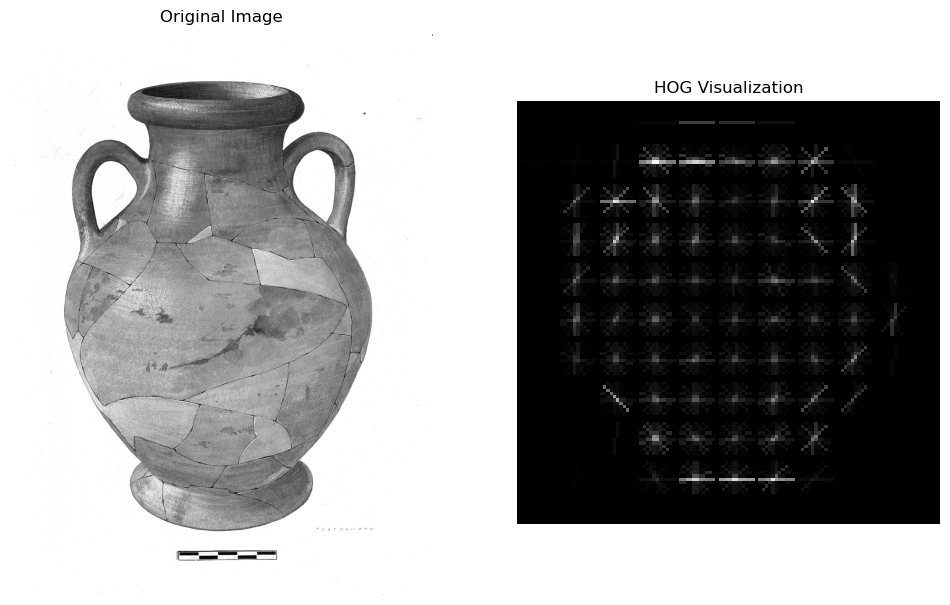

In [51]:
example_filename = data["ImageFilename"][4]
example_image = cv_read(example_filename)
hog_example_vec, hog_example_image = extract_hog_features(example_filename, return_image=True)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(example_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hog_example_image, cmap='gray')
plt.title("HOG Visualization")
plt.axis('off')
plt.show()

In [52]:
hog_features = data["ImageFilename"].apply(extract_hog_features).tolist()
hog_features = to_df(np.array(hog_features), offset=1)
hog_features

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F2907,F2908,F2909,F2910,F2911,F2912,F2913,F2914,F2915,F2916
0,0.425344,0.019556,0.114273,0.032412,0.440224,0.039923,0.032794,0.006030,0.371680,0.033114,...,0.023749,0.057730,0.076499,0.068273,0.079507,0.086426,0.093759,0.062853,0.071099,0.017039
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.010412,0.000000,0.000000,0.000000,0.020825,0.000000,0.000000,0.000000,0.000000,0.010412,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996,0.577127,0.468978,0.078133,0.003985,0.475851,0.000000,0.000000,0.025517,0.356698,0.000000,...,0.035604,0.012202,0.049885,0.118185,0.208833,0.172656,0.095851,0.113848,0.039816,0.013399
1997,0.193679,0.138322,0.128968,0.186310,0.184128,0.127358,0.139412,0.084249,0.095108,0.196215,...,0.154563,0.125848,0.119905,0.152948,0.132633,0.164342,0.100512,0.171129,0.088452,0.205758
1998,0.229721,0.055162,0.179240,0.135910,0.228854,0.223184,0.116055,0.096111,0.147025,0.229721,...,0.029141,0.091007,0.070742,0.040053,0.095052,0.064881,0.056673,0.034866,0.023789,0.031382


In [53]:
hog_features.shape

(2000, 2916)

**Merge Canny + HOG**

Merging both creates a single input that contains:
- structural shape info (HOG).
- edge density / contrast info (Canny).

This helps your model understand both shape and texture distribution — especially useful for classical models which don't "see" raw images the way CNNs do.

In [54]:
canny_hog_features = pd.concat([canny_features, hog_features], axis=1)
canny_hog_features

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F2907,F2908,F2909,F2910,F2911,F2912,F2913,F2914,F2915,F2916
0,1462.0,0.425344,0.019556,0.114273,0.032412,0.440224,0.039923,0.032794,0.006030,0.371680,...,0.023749,0.057730,0.076499,0.068273,0.079507,0.086426,0.093759,0.062853,0.071099,0.017039
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2064.0,0.010412,0.000000,0.000000,0.000000,0.020825,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1996,1163.0,0.577127,0.468978,0.078133,0.003985,0.475851,0.000000,0.000000,0.025517,0.356698,...,0.035604,0.012202,0.049885,0.118185,0.208833,0.172656,0.095851,0.113848,0.039816,0.013399
1997,613.0,0.193679,0.138322,0.128968,0.186310,0.184128,0.127358,0.139412,0.084249,0.095108,...,0.154563,0.125848,0.119905,0.152948,0.132633,0.164342,0.100512,0.171129,0.088452,0.205758
1998,762.0,0.229721,0.055162,0.179240,0.135910,0.228854,0.223184,0.116055,0.096111,0.147025,...,0.029141,0.091007,0.070742,0.040053,0.095052,0.064881,0.056673,0.034866,0.023789,0.031382


In [55]:
export_vectors(canny_hog_features, 'image', 'cannyhog')